# Работа.ру. Предсказание зарплат. 
## Обработка навыков

<p style="font-size: 12pt">
    <b>Общая задача:</b> предсказать зарплату по резюме/вакансии на основе данных.
</p>
<p style="font-size: 12pt">
    <b>Подзадача:</b> отчистить поле <i>навыки</i> от мусора и обеспечить интерпретируемость вклада каждого навыка в зарплату для конкретной профессии.
</p>
<p style="font-size: 12pt">
    <b>Данные:</b> датасет <i>data_vacancies.csv</i>
    <ul>
        <li>Профессия</li>
        <li>График работы</li>
        <li>Локация</li>
        <li>Навыки</li>
    </ul>
</p>    
<p style="font-size: 12pt">
    <b>Бейзлайн:</b> преобразовать данные указанных полей в числовой/векторный вид, обучить модель линейной регрессии, метрика MAPE
</p>    

In [1]:
# !pip install -U spacy
# !python -m spacy download ru_core_news_sm
# !pip install gensim
# !pip install fasttext

In [2]:
# подключение библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import spacy
import gensim.models
import fasttext
import fasttext.util

In [3]:
# функция, возвращает векторизированное предложение
def get_vector(model, sentence, vector_size=100):
    sentence_vector = []

    if len(sentence) == 0:
        # Пустые предложения заполним их одним  словом
        token_vector = np.zeros(vector_size)
        sentence_vector.append(token_vector)
    else:
        for token in sentence:
            try:
                token_vector = model.wv[token]
            except KeyError as e:
                print('here')
                # Случай неизвестного слова
                token_vector = np.zeros(vector_size)
            finally:
                sentence_vector.append(token_vector)
    
    return np.mean(sentence_vector, axis=0)


# функция, возвращает векторизированные выборки
def vectorize_train_test(model, X_train, X_test, vector_size=100):
    X_train_vectorized = np.zeros((X_train.shape[0], vector_size))
    for index, sentence in enumerate(X_train):
        X_train_vectorized[index] = get_vector(model, sentence, vector_size)

    X_test_vectorized = np.zeros((X_test.shape[0], vector_size))
    for index, sentence in enumerate(X_test):
        X_test_vectorized[index] = get_vector(model, sentence)

    return X_train_vectorized, X_test_vectorized


"""
Функция, считает:
 - среднюю вероятность схожести с соседом
 - среднее косинусное расстояние между схожими словами
"""
def calculate_metrics(model):
    words = model.wv.key_to_index.keys()
    mean_proba = 0
    mean_distance = 0

    for word in words:
        candidate = model.wv.most_similar(positive=[word], topn=1)[0]
        mean_distance += model.wv.distance(candidate[0], word)
        mean_proba += candidate[1]

    return mean_proba / len(words), mean_distance / len(words)

### Загрузка датасета

In [4]:
df = pd.read_csv('./data/data_vacancies.csv')
df.head(5)

,id,custom_position,schedule,salary_from,salary_to,salary_pay_type,offer_education_id,education_name,education_is_base,education_order_num,city_id,list_regions,work_skills,tags_id
0,48202096,Сварщик-сборщик,полный рабочий день,60000,120000,NaN,0,любое,True,0,2,[4],"['сварочные работы', 'сборка изделий по чертеж...",NaN
1,48202097,Сварщик-монтажник,полный рабочий день,60000,120000,NaN,0,любое,True,0,2,[4],"['монтажные работы', 'строительные работы', 'э...",NaN
2,48202098,Слесарь-сборщик,полный рабочий день,60000,80000,NaN,0,любое,True,0,2,[4],"['работа на фрезерных станках', 'слесарный рем...",NaN
3,48202356,Грузчик-упаковщик,частичная занятость,30000,35000,NaN,0,любое,True,0,1,[3],"['комплектация товара', 'маркировка', 'стрессо...","[6, 9]"
4,48202357,Грузчик-упаковщик,частичная занятость,30000,35000,NaN,0,любое,True,0,57,"[181, 182, 183, 185, 186, 187, 188, 189, 190, ...","['маркировка', 'стрессоустойчивость', 'погрузо...","[6, 9]"


### Разведочный анализ

Text(0.5, 1.0, 'Гистограмма education_name')

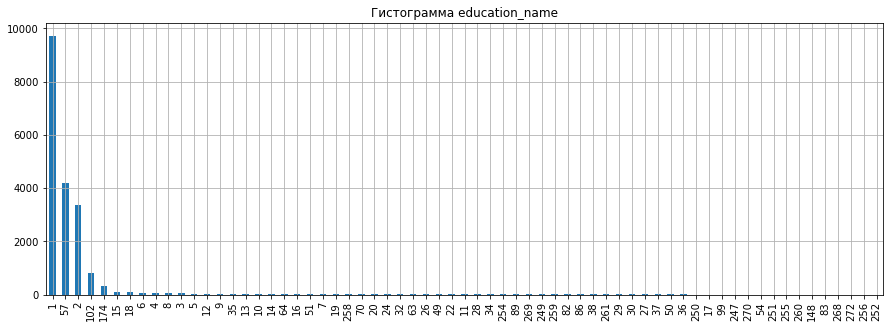

In [5]:
plt.figure(figsize=(15, 5))
df['city_id'].value_counts().plot(kind='bar', grid=True)
plt.title("Гистограмма education_name")

<AxesSubplot:>

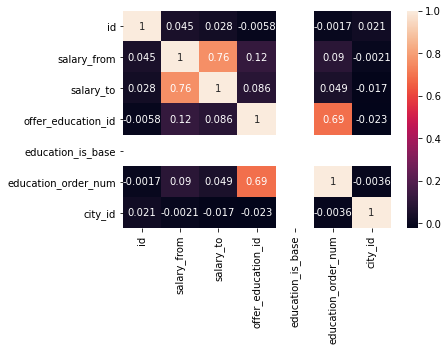

In [6]:
sns.heatmap(df.corr(), annot=True)

### Предобработка

##### Выберим необходимые поля

In [7]:
df = df[['custom_position', 'schedule', 'salary_from', 'city_id', 'work_skills']]
df.head(5)

,custom_position,schedule,salary_from,city_id,work_skills
0,Сварщик-сборщик,полный рабочий день,60000,2,"['сварочные работы', 'сборка изделий по чертеж..."
1,Сварщик-монтажник,полный рабочий день,60000,2,"['монтажные работы', 'строительные работы', 'э..."
2,Слесарь-сборщик,полный рабочий день,60000,2,"['работа на фрезерных станках', 'слесарный рем..."
3,Грузчик-упаковщик,частичная занятость,30000,1,"['комплектация товара', 'маркировка', 'стрессо..."
4,Грузчик-упаковщик,частичная занятость,30000,57,"['маркировка', 'стрессоустойчивость', 'погрузо..."


##### Возьмем вакансии для топ5 локаций

In [8]:
top5_loc = df['city_id'].value_counts()[:5].index.tolist()
df = df[df['city_id'].isin(top5_loc)]
df.head(5)

,custom_position,schedule,salary_from,city_id,work_skills
0,Сварщик-сборщик,полный рабочий день,60000,2,"['сварочные работы', 'сборка изделий по чертеж..."
1,Сварщик-монтажник,полный рабочий день,60000,2,"['монтажные работы', 'строительные работы', 'э..."
2,Слесарь-сборщик,полный рабочий день,60000,2,"['работа на фрезерных станках', 'слесарный рем..."
3,Грузчик-упаковщик,частичная занятость,30000,1,"['комплектация товара', 'маркировка', 'стрессо..."
4,Грузчик-упаковщик,частичная занятость,30000,57,"['маркировка', 'стрессоустойчивость', 'погрузо..."


##### Проверим пропуски

In [9]:
df.isna().sum()

custom_position    0
schedule           0
salary_from        0
city_id            0
work_skills        0
dtype: int64

In [10]:
df['schedule'].unique()

array(['полный рабочий день', 'частичная занятость', 'сменный график',
       'свободный график', 'вахта', 'удаленная работа'], dtype=object)

In [11]:
df['city_id'].unique()

array([  2,   1,  57, 102, 174], dtype=int64)

##### OneHotEncoding полей city_id и schedule

In [12]:
city_id_one = pd.get_dummies(df['city_id'], prefix='city_id')
schedule_one = pd.get_dummies(df['schedule'], prefix='schedule')

df = pd.concat([df, city_id_one], axis=1)
df = pd.concat([df, schedule_one], axis=1)

df.drop(columns=['city_id'], inplace=True)
df.drop(columns=['schedule'], inplace=True)
df.head(5)

,custom_position,salary_from,work_skills,city_id_1,city_id_2,city_id_57,city_id_102,city_id_174,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость
0,Сварщик-сборщик,60000,"['сварочные работы', 'сборка изделий по чертеж...",0,1,0,0,0,0,1,0,0,0,0
1,Сварщик-монтажник,60000,"['монтажные работы', 'строительные работы', 'э...",0,1,0,0,0,0,1,0,0,0,0
2,Слесарь-сборщик,60000,"['работа на фрезерных станках', 'слесарный рем...",0,1,0,0,0,0,1,0,0,0,0
3,Грузчик-упаковщик,30000,"['комплектация товара', 'маркировка', 'стрессо...",1,0,0,0,0,0,0,0,0,0,1
4,Грузчик-упаковщик,30000,"['маркировка', 'стрессоустойчивость', 'погрузо...",0,0,1,0,0,0,0,0,0,0,1


##### Нормализация и токенизации поля custom_position

In [13]:
nlp = spacy.load('ru_core_news_sm')

df['custom_position_clear'] = df['custom_position'].apply(
    lambda x: [str(token).lower() for token in nlp(x) if
      not token.is_stop
      and not token.is_punct
      and not token.is_digit
      and not token.like_email
      and not token.like_num
      and not token.is_space
    ]
  )

df.drop(columns=['custom_position'], inplace=True)
df.head(5)

,salary_from,work_skills,city_id_1,city_id_2,city_id_57,city_id_102,city_id_174,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,custom_position_clear
0,60000,"['сварочные работы', 'сборка изделий по чертеж...",0,1,0,0,0,0,1,0,0,0,0,"[сварщик, сборщик]"
1,60000,"['монтажные работы', 'строительные работы', 'э...",0,1,0,0,0,0,1,0,0,0,0,"[сварщик, монтажник]"
2,60000,"['работа на фрезерных станках', 'слесарный рем...",0,1,0,0,0,0,1,0,0,0,0,"[слесарь, сборщик]"
3,30000,"['комплектация товара', 'маркировка', 'стрессо...",1,0,0,0,0,0,0,0,0,0,1,"[грузчик, упаковщик]"
4,30000,"['маркировка', 'стрессоустойчивость', 'погрузо...",0,0,1,0,0,0,0,0,0,0,1,"[грузчик, упаковщик]"


##### Тренеровочная/тестовая выборки

In [14]:
df.drop(columns=['work_skills'], inplace=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'salary_from'], df['salary_from'],
                                                    random_state=2023)

##### Векторизация предложений

### ТЕСТ

In [16]:
# gensim.models.FastText??

In [17]:
mape = []
r2_scores = []
mean_probas = []
mean_distances = []

for epochs in tqdm(range(5, 110, 5)):
    # получение embeddings
    fasttext = gensim.models.FastText(vector_size=100, min_count=1)
    fasttext.build_vocab(corpus_iterable=X_train['custom_position_clear'])

    fasttext.train(
        corpus_iterable=X_train['custom_position_clear'],
        total_examples=len(X_train['custom_position_clear']),
        epochs=epochs
        )

    mean_proba, mean_distance = calculate_metrics(fasttext)
    
    cuspos_vec_train, cuspos_vec_test = vectorize_train_test(fasttext, 
                                                             X_train['custom_position_clear'], 
                                                             X_test['custom_position_clear'])

    cuspos_vec_train = pd.DataFrame(cuspos_vec_train).add_prefix('custom_position_')
    cuspos_vec_test = pd.DataFrame(cuspos_vec_test).add_prefix('custom_position_')

    X_train_temp = pd.concat([X_train.reset_index(drop=True), cuspos_vec_train], axis=1)
    X_test_temp = pd.concat([X_test.reset_index(drop=True), cuspos_vec_test], axis=1)

    X_train_temp.drop(columns=['custom_position_clear'], inplace=True)
    X_test_temp.drop(columns=['custom_position_clear'], inplace=True)
    
    reg = LinearRegression().fit(X_train_temp, y_train)
    y_pred = reg.predict(X_test_temp)
    
    mape.append(mean_absolute_percentage_error(y_test, y_pred))
    mean_probas.append(mean_proba)
    mean_distances.append(mean_distance)
    r2_scores.append(reg.score(X_test_temp, y_test))

  0%|          | 0/21 [00:00<?, ?it/s]

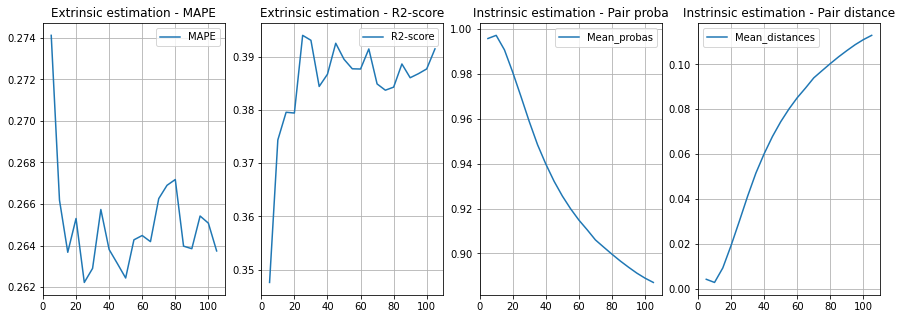

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].plot(np.arange(5, 110, 5), mape, label='MAPE') # extrinsic
ax[1].plot(np.arange(5, 110, 5), r2_scores, label='R2-score') # intrinsic
ax[2].plot(np.arange(5, 110, 5), mean_probas, label='Mean_probas') # intrinsic
ax[3].plot(np.arange(5, 110, 5), mean_distances, label='Mean_distances') # intrinsic

ax[0].set_title("Extrinsic estimation - MAPE")
ax[1].set_title("Extrinsic estimation - R2-score")
ax[2].set_title("Instrinsic estimation - Pair proba")
ax[3].set_title("Instrinsic estimation - Pair distance")


ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

In [21]:
X_train.shape[1] + 100

112

Рост размерности -> больше данных \
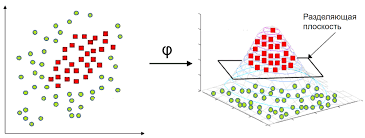

**Что посмотреть:**
1. Уменьшить размерность (без work_skills), посмотреть, как изменится метрика
2. Сформировать пары слов
3. Tf-idf
4. Fasttext: посмотреть размерность для work_skills

### Тест

Без предобученныого Fasttext
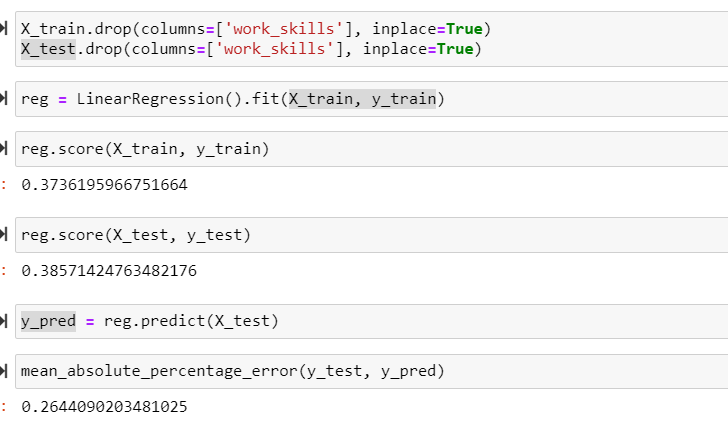

Предобученныый Fasttext
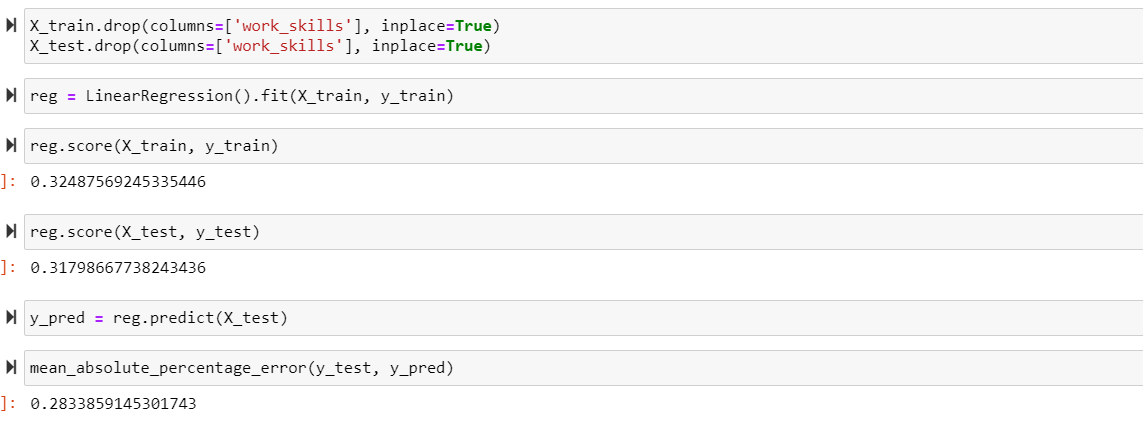